In [3]:
from s3prl.downstream.mdd.dataset import L2ArcticDataset
from s3prl.downstream.augment_utils.add_noise import AddNoise
from IPython.display import Audio, display
from pathlib import Path
import torch
import torchaudio
import numpy as np

In [28]:
folder = Path('/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/rir/Audio')

wavs = []
srs = []

for path in folder.iterdir():
    if path.suffix != '.wav':
        continue
    wav, sr = torchaudio.load(path)
    wav = wav.squeeze()
    wav = wav / wav.norm()
    wavs.append(wav)
    srs.append(sr)
sr = srs[0]


In [29]:
wavs[0].shape

torch.Size([14950])

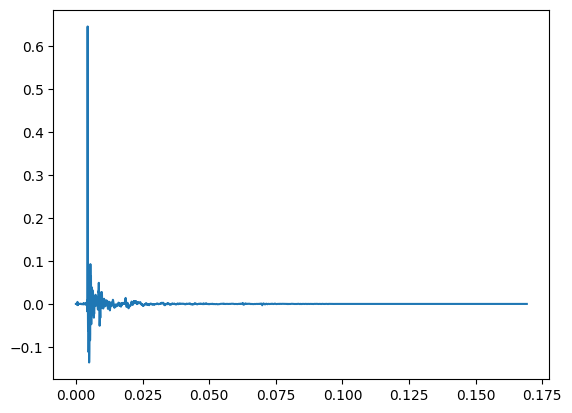

In [30]:
from matplotlib import pyplot as plt

def plot(wav):
    plt.plot(np.linspace(0, len(wav) / sr, wav.shape[-1]), wav)

plot(wavs[3])

In [18]:
Audio(wavs[150].flip(-1), rate=32000)

In [19]:
dataset = L2ArcticDataset(
    "train",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/downstream/mdd/data/",
)

Skipping malformatted TextGrid file: /home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0/YDCK/annotation/arctic_a0272.TextGrid
Skipping malformatted TextGrid file: /home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0/YDCK/annotation/arctic_a0209.TextGrid


In [31]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    display(Audio(waveform, rate=sample_rate))


audio = [
    torchaudio.functional.resample(dataset[0][0], orig_freq=44100, new_freq=16000),
    torchaudio.functional.resample(dataset[1][0], orig_freq=44100, new_freq=16000),
]

In [33]:
Audio(torchaudio.functional.fftconvolve(audio[0], wavs[240]), rate=16000)

In [108]:
wav, sr = torchaudio.load('reverb.wav')

display(sr)

# wav = torchaudio.functional.resample(wav, sr, 16000)

wav = wav / np.linalg.norm(wav)

16000

In [111]:
wav.shape

torch.Size([2, 4757])

In [113]:
Audio(torchaudio.functional.fftconvolve(audio[0], wav[0]), rate=16000)

In [88]:
Audio(audio[0], rate=16000)

In [ ]:
sr

16000

In [72]:
display(Audio(wav, rate=sr))

In [ ]:
play_audio(audio[0], 16000)

In [ ]:
augmentation = AddNoise(
    prob=1.0,
    snr_low=0,
    snr_high=0.4,
    device="cpu",
    seed=1337,
)
audio = torch.nn.utils.rnn.pad_sequence(audio, batch_first=True)
lens = torch.tensor([len(audio[0]), len(audio[1])], dtype=torch.long)
aug_audio =     augmentation(
        audio,
        lens,
    )
play_audio(
    aug_audio[0],
    sample_rate=16000,
)

audio - aug_audio

tensor([[ 2.0554e-05, -5.1542e-05, -3.2218e-05,  ...,  2.9547e-04,
         -6.1925e-05,  8.1545e-05],
        [ 3.7022e-03, -5.9150e-03,  1.2691e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])